In [14]:
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import seaborn as sns
import tqdm

In [15]:
# Constants

GAMMA = 0.9
ALPHA = 0.1

In [16]:
# testing the environment

env = gym.make('Taxi-v3')
n_states = env.observation_space.n
n_actions = env.action_space.n
print(n_states, n_actions)

500 6


Environment description<br>
    - 5 x 5<br>
    - at start of episode taxi starts at random position and passenger<br>
        is at a random poistion of the 4 designated locations.<br>
    - taxi drives to passengers location and drops him off (episode ends)
    <br>
    - total states = 25 * 5 * 4 

# SMDP Q-Learning


Whole action set:<br>
    - 6 primitive actions: 0 - 5<br>
    - move taxi to each of the 4 destinations [options]: 6 - 9<br>


In [17]:

rewards = []
num_episodes = 1500
n_options = 4

# a dictionary to store the locations of the 4 options
locations = {0:[0,0], 1:[0,4], 2:[4,0], 3:[4,3]}

# a dictionary of Q-value for each option
Q = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(n_options)} #Q-values for each option

In [18]:
def epsilon_greedy_policy(Q, state, epsilon):
    '''Epsilon greedy policy,
        returns the action to be taken based on the Q-values'''
    if np.random.uniform() < epsilon:
        return np.random.choice(env.action_space.n-2)
    else:
        return np.argmax(Q[state])

In [22]:
def Option(env, state, goal, Q, eps):
    '''The option function that chooses the action for the 
    agent to take based on the goal, basically 
    we have four options: each corresponding to a destination'''

    option_done = False
    x,y,pickup,dropoff = env.decode(state)

    if([x,y] == locations[goal]):
        option_done = True
        if(pickup == goal):
            #Agent is at pickup location, so choose to pickup
            option_act = 4
        else:
            #Agent is at dropoff location, so choose to dropoff
            option_act = 5
    else:
        #Agent is not at the goal location, so move towards
        option_act = epsilon_greedy_policy(Q[goal], 5*x+y, epsilon=eps) 
    return option_done, option_act
    

In [20]:
#Training the agent

# a dictionary to store the epsilon values for each option
eps = {i:0.1 for i in range(n_options)}
eps_min = 0.01
eps_decay = 0.99

for i in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0
    done = False
    while not done:
        x,y, pickup, dropoff = env.decode(state)
        find_passenger = False
        option = pickup
        total_reward = 0

        #option<4 means that passenger is in the taxi

        '''Find the passenger and move towards the passenger location,
        use the pickup location as option'''
        while not find_passenger and not done and option<4:
            find_passenger, option_act = Option(env,state,pickup,Q,eps[option])
            [x,y,_,_]=  list(env.decode(state))  
            next_state, reward, done,_ ,_ = env.step(option_act)
            [x1,y1,_,_]=  list(env.decode(next_state)) 

            total_reward+=reward
            eps[option] = max(eps_min,eps_decay*eps[option])
            reward_surr = reward
            if find_passenger:
                reward_surr = 20
            if option_act<4:  
                Q[option][5*x+y, option_act] = Q[option][5*x+y, option_act] + ALPHA*(reward_surr + GAMMA*np.max(Q[option][5*x1+y1, :]) - Q[option][5*x+y, option_act])
            state = next_state

        '''Choose the option to reach the destination and drop them off.'''
        x, y, pickup, dropoff = env.decode(state)
        dropoff_passenger = False
        option = dropoff
        while not find_passenger and not done:
            dropoff_passenger, option_act = Option(env,state,dropoff,Q,eps[option])
            [x,y,_,_]=  list(env.decode(state))  
            next_state, reward, done,_ ,_ = env.step(option_act)
            [x1,y1,_,_]=  list(env.decode(next_state)) 
            total_reward+=reward
            eps[option] = max(eps_min,eps_decay*eps[option])
            reward_surr = reward
            if dropoff_passenger:
                reward_surr = 20
            if option_act<4:  
                Q[option][5*x+y, option_act] = Q[option][5*x+y, option_act] + ALPHA*(reward_surr + GAMMA*np.max(Q[option][5*x1+y1, :]) - Q[option][5*x+y, option_act])
            state = next_state

        episode_reward+=total_reward
    rewards.append(episode_reward)

c:\Users\akran\anaconda3\envs\env_pytorch\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(


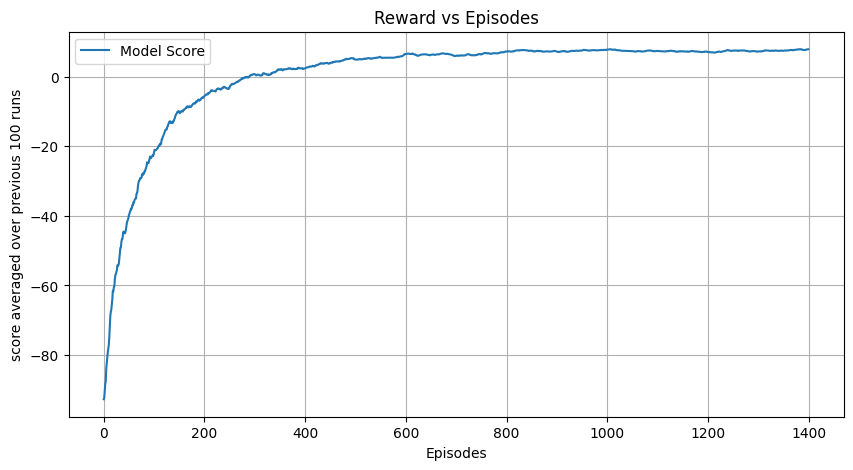

In [23]:
# Plots reward curve
plt.figure(figsize = (10,5))
avg_rews1 = [np.average(rewards[i:i+100]) for i in range(len(rewards)-100)]
plt.plot(avg_rews1,label = 'Model Score')
# plt.plot([9.7 for i in range(len(avg_rews1))],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.grid()
plt.title('Reward vs Episodes')
plt.legend()
plt.savefig("Plots/SMDP/reward_vs_episodes.png")
     

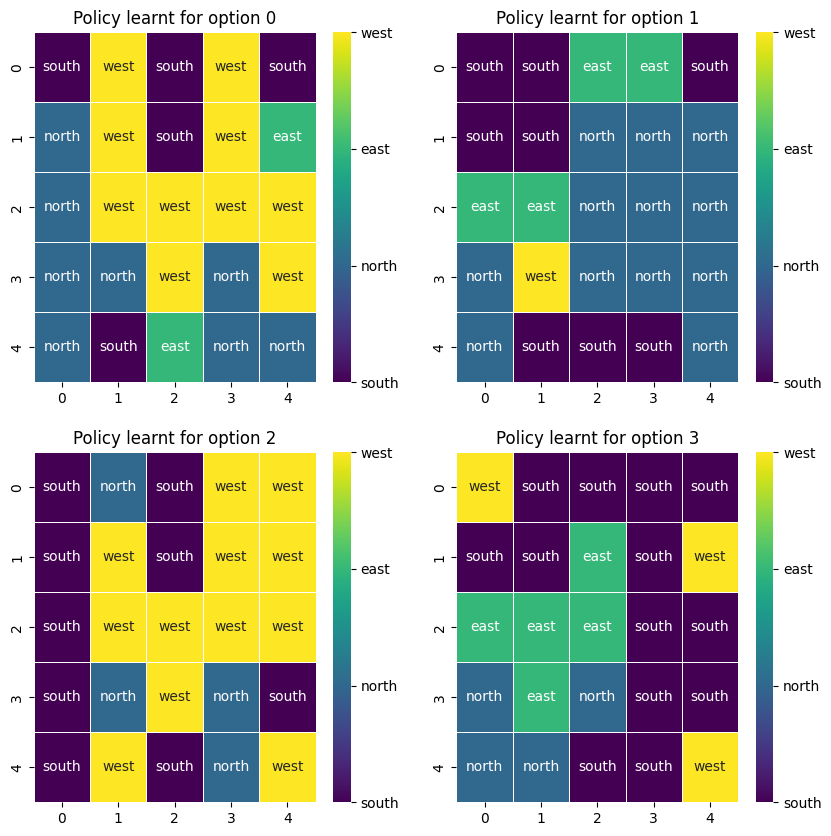

In [24]:
#Plots the learnt policy for each option
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west'}
    annot_text = np.vectorize(labels.get)(np.argmax(Q[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Q[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='', cmap="viridis", linewidths=0.5, linecolor='white')
    axis[i,j].set_title("Policy learnt for option {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])
plt.savefig("Plots/SMDP/learned_Q_values.png")


### Task-3, Other options

Theoretically speaking there should be atleast 4 options/sub-goals,
right? otherwise say if i have 3 subgoals to reach goals near the destination
then because the policy is deterministic based on the learned Q-values, i can never reach a destination.

# Intra option Q-Learning

One drawback to SMDP learning methods is that they need to execute an option to
termination before they can learn about it. Because of this, they can only be applied
to one option at a time–the option that is executing at that time. More interesting
and potentially more powerful methods are possible by taking advantage of the
structure inside each option. In particular, if the options are Markov and we are
willing to look inside them, then we can use special temporal-difference methods
to learn usefully about an option before the option terminates. This is the main idea
behind intra-option methods<br>
Intra-option methods are examples of off-policy learning methods (Sutton and
Barto, 1998) because they learn about the consequences of one policy while actually
behaving according to another, potentially different policy. Intra-option methods
can be used to simultaneously learn about many different options from the same
experience. Moreover, they can learn about the values of executing certain options
without ever executing those options.<br>
This is the idea of off-policy training—to make full
use of whatever experience occurs in order to learn as much possible about all op-
tions, irrespective of their role in generating the experience<br>

In [27]:
rewards = []
passenger_locations = 5
drop_locations = 4
n_options = 4

In [28]:

def Sub(state, nPas = passenger_locations, nDrop = drop_locations):
  _,_,pas,drop = env.decode(state) 
  subState = nDrop*pas+drop 
  return subState 

In [29]:
def Option(env, state, goal, Q, eps):
    option_done = False
    x,y,pickup,dropoff = env.decode(state)
    #print(x,y,pickup,dropoff,locations[goal])
    if([x,y] == locations[goal]):
        option_done = True
        if(pickup == goal):
            #Agent is at pickup location, so choose to pickup
            option_act = 4
        else:
            #Agent is at dropoff location, so choose to dropoff
            option_act = 5
    else:
        #Agent is not at the goal location, so move towards
        option_act = epsilon_greedy_policy(Q[goal], 5*x+y, epsilon=eps) 
    return option_done, option_act
    

In [30]:
# Training the agent

q_values_IOQL = np.zeros((passenger_locations*drop_locations,n_options))
updates_IOQL = np.zeros((passenger_locations*drop_locations,n_options))

# Q value for each option
Q = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(n_options)} #Q-values for each option

# a dictionary to store the epsilon values for each option
eps = {i:0.01 for i in range(n_options)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5

count = 0
Neps = 1500

# Iterate over Number of episodes
for i in tqdm.tqdm(range(Neps)):
    state, _ = env.reset()    
    done = False
    episode_reward = 0

    # While episode is not over
    while not done:
        # Choose action  
        _,_,pickup,dropoff = env.decode(state) 
        subState = drop_locations*pickup+dropoff      
        action = epsilon_greedy_policy(q_values_IOQL, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_main*eps_decay)
        

        option = action
        find_passenger = False
        prev = state  
        while not find_passenger and not done:
            #print(env,state,Q,option,eps[option])
            find_passenger,option_act = Option(env,state,option, Q, eps[option])
            next_state, reward, done,_ ,_ = env.step(option_act)
            
            episode_reward+=reward
            #Option Policy Learning
            [x,y,_,_]=  list(env.decode(state)) 
            [x1,y1,_,_]=  list(env.decode(next_state)) 

            eps[option] = max(eps_min,eps_decay*eps[option])
            reward_surr = reward
            if find_passenger:
              reward_surr = 20
            if option_act<4:  
              Q[option][5*x+y, option_act] = Q[option][5*x+y, option_act] + ALPHA*(reward_surr + GAMMA*np.max(Q[option][5*x1+y1, :]) - Q[option][5*x+y, option_act])



            #finding all options giving same action call
            
            for o in range(n_options):
              optdone_o, optact_o = Option(env,state,o,Q,eps[o])
              if optact_o == option_act:
                eps[o] = max(eps_min,eps_decay*eps[o])
                if optdone_o:
                  q_values_IOQL[Sub(state), o] += ALPHA*(reward + GAMMA*np.max(q_values_IOQL[Sub(next_state), :]) - q_values_IOQL[Sub(state), o])
                else:
                  q_values_IOQL[Sub(state), o] += ALPHA*(reward + GAMMA*q_values_IOQL[Sub(next_state), o] - q_values_IOQL[Sub(state), o]) 

                updates_IOQL[Sub(state), o] += 1
            state = next_state 
        
    rewards.append(episode_reward) 

  0%|          | 0/1500 [00:00<?, ?it/s]

c:\Users\akran\anaconda3\envs\env_pytorch\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 1500/1500 [00:08<00:00, 176.73it/s]


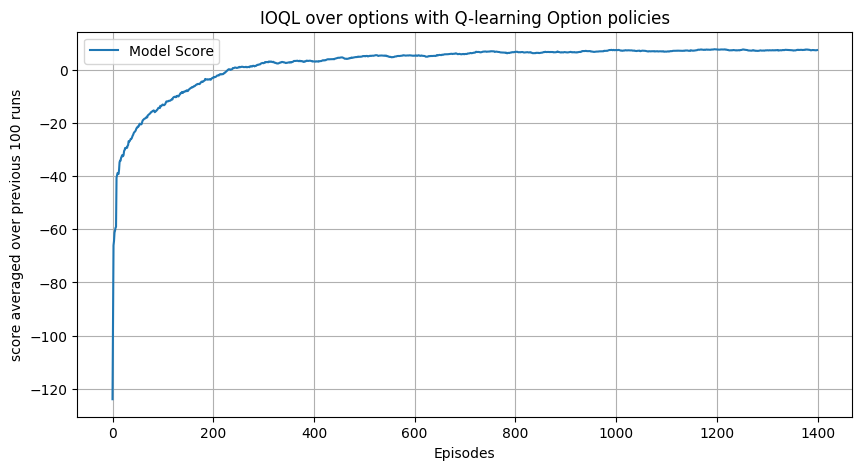

In [33]:
plt.figure(figsize = (10,5))
avg_rews = [np.average(rewards[i:i+100]) for i in range(len(rewards)-100)]
plt.plot(avg_rews,label = 'Model Score')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('IOQL over options with Q-learning Option policies')
plt.legend()
plt.grid()
plt.savefig("Plots/IOQL/reward_vs_episodes.png")

In [37]:
Qmax_IOQL

array([[0, 0, 0, 0],
       [1, 0, 1, 1],
       [2, 2, 0, 2],
       [3, 3, 3, 0],
       [0, 1, 2, 3]], dtype=int64)

Text(0.5, 1.0, 'Policy over options learnt by Intra Options')

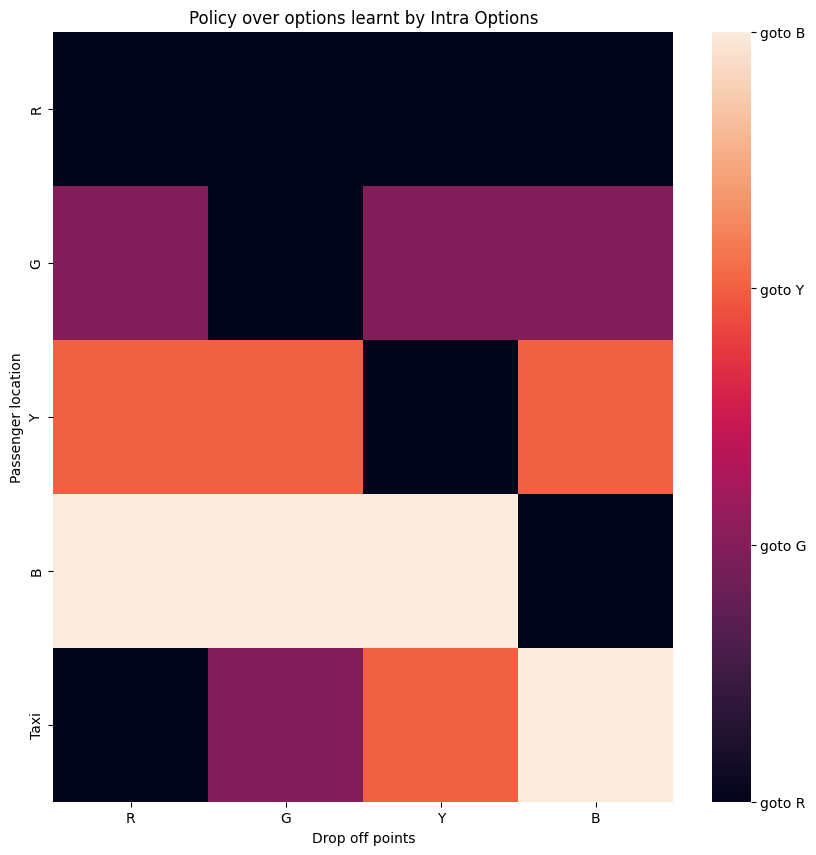

In [38]:
Qmax_IOQL = np.argmax(q_values_IOQL[:,-4:],axis = 1).reshape(5,4)
figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_IOQL,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'])
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(4)])
# c_bar.set_ticklabels(['south','north','east','west','pick up','drop','goto R','goto G', 'goto Y', 'goto B'])
c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])
axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy over options learnt by Intra Options')

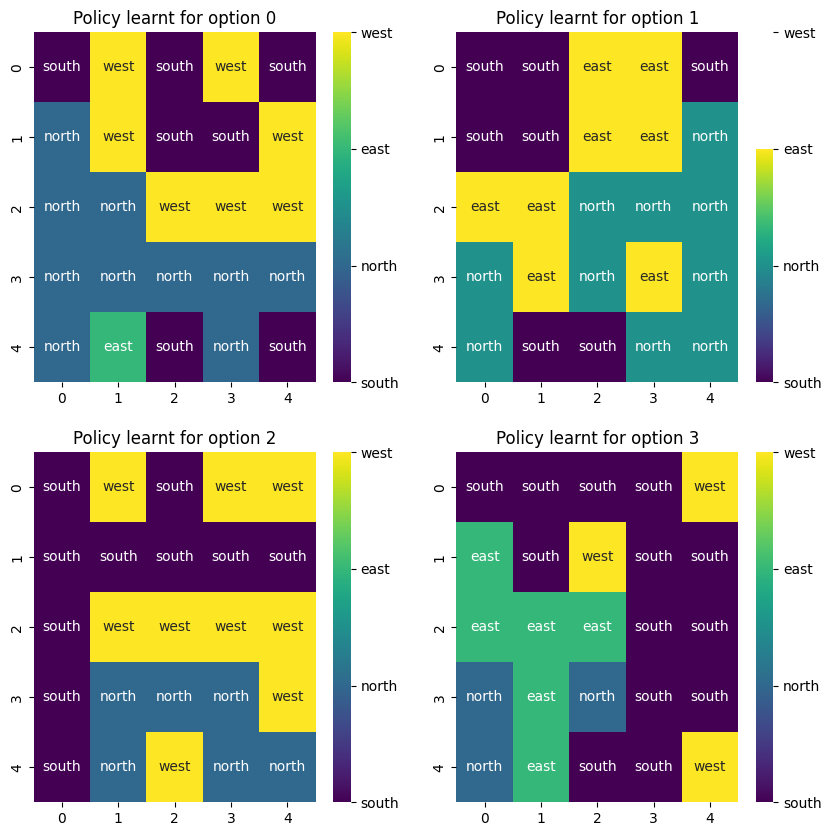

In [39]:
# plot the learned Q-values for each option
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west'}
    annot_text = np.vectorize(labels.get)(np.argmax(Q[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Q[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='', cmap="viridis")
    axis[i,j].set_title("Policy learnt for option {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])

plt.savefig("Plots/IOQL/learned_Q_values.png")